In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.special import iv
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow_probability as tfp
import warnings
import pandas as pd
import statsmodels.api as sm
import tensorflow_probability as tfp
import tqdm
import mpmath
import scipy

In [2]:
def random_VMF(mu, kappa, size=None):
    n = 1 if size is None else np.product(size)
    shape = () if size is None else tuple(np.ravel(size))
    mu = np.asarray(mu)
    mu = mu / np.linalg.norm(mu)
    (d,) = mu.shape
    # z component: radial samples perpendicular to mu
    z = np.random.normal(0, 1, (n, d))
    z /= np.linalg.norm(z, axis=1, keepdims=True)
    z = z - (z @ mu[:, None]) * mu[None, :]
    z /= np.linalg.norm(z, axis=1, keepdims=True)
    # sample angles (in cos and sin form)
    cos = _random_VMF_cos(d, kappa, n)
    sin = np.sqrt(1 - cos ** 2)
    # combine angles with the z component
    x = z * sin[:, None] + cos[:, None] * mu[None, :]
    return x.reshape((*shape, d))


def _random_VMF_cos(d: int, kappa: float, n: int):

    b = (d - 1) / (2 * kappa + (4 * kappa ** 2 + (d - 1) ** 2) ** 0.5)
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0 ** 2)
    found = 0
    out = []
    while found < n:
        m = min(n, int((n - found) * 1.5))
        z = np.random.beta((d - 1) / 2, (d - 1) / 2, size=m)
        t = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        test = kappa * t + (d - 1) * np.log(1 - x0 * t) - c
        accept = test >= -np.random.exponential(size=m)
        out.append(t[accept])
        found += len(out[-1])
    return np.concatenate(out)[:n]

def gamma(t, kappa=0.6):
    return t**(-kappa)


def LogQ(x1,grad1,kappa1,x2,grad2,kappa2):
  p = len(x1)
  d = p/2 - 1
  br = float(mpmath.log(mpmath.besseli(d, kappa1)/mpmath.besseli(d, kappa2)))


  return  0.5*(np.dot(grad1,x1) -np.dot(grad2,x2)) - br + d* np.log(kappa1/kappa2)

In [3]:
def algorithms(algo,N,x_curr,f,grad,sigma = None,precond = True):
    d = len(x_curr)
    if algo == "RWM":
      target_ap = 0.234
      if sigma is None:
        sigma =  2.4*(d**(-1/2))
    elif algo == "MALA":
      target_ap = 0.574
      if sigma is None:
        sigma = 2.4*(d**(-1/6))
    elif algo == "HS":
      target_ap = 0.55
      if sigma is None:
        sigma = 2.4*(d**(1/3))


    sigmas = np.zeros(N)
    sigmas[0] = sigma

    x = x_curr
    x_samples = np.zeros((N, d))
    x_samples[0] = x

    diag_var = np.ones(d)
    diag_t = np.zeros((N, d))
    diag_t[0] = diag_var
    mu = x

    R = tqdm.tqdm(range(1,N))
    for t in R:
        ############ PROPOSAL ################
        if algo == "RWM":
          if precond:
             y = x + sigma*np.random.normal(loc=np.zeros(d), scale=np.sqrt(diag_var), size=d)
          else:
            y = x + sigma*np.random.normal(size=d)

        elif algo == "MALA":

          grad_x = grad(x)
          if precond:
            y = x + (sigma * np.sqrt(diag_var)) * np.random.normal(size=d) + (sigma * np.sqrt(diag_var)) ** 2 * grad_x  / 2
          else:
            y = x + sigma * np.random.normal(size=d) + sigma**2 / 2 * grad_x

        elif algo == "HS":

          grad_x = grad(x)
          norm_x = np.linalg.norm(grad_x)
          mu_x = grad_x/norm_x
          kappa_x = 0.5*sigma*norm_x
          y = x + sigma*random_VMF(mu_x, kappa_x)

        ################## ACCEPTANCE #####################


        if algo == "RWM":
          loga = f(y) - f(x)

        elif algo == "MALA":
          if precond:
            loga = f(y) - f(x) + np.sum(-((x - y - (sigma * np.sqrt(diag_var)) ** 2 * grad(y) / 2) ** 2) / (2 * (sigma * np.sqrt(diag_var)) ** 2) + ((y - x - (sigma * np.sqrt(diag_var)) ** 2 * grad(x) / 2) ** 2) / (2 * (sigma * np.sqrt(diag_var)) ** 2))
          else:
            loga = f(y) - f(x) + np.sum(norm.logpdf(x - y, loc=sigma**2 / 2 * grad(y), scale=sigma)) - np.sum(norm.logpdf(y-x, loc=sigma**2 / 2 * grad_x, scale=sigma))

        elif algo == "HS":
          grad_y = grad(y)
          norm_y = np.linalg.norm(grad_y)
          mu_y = grad_y/norm_y
          kappa_y = 0.5*sigma*norm_y

          delta_x = (x-y)/np.linalg.norm(x-y)
          delta_y = (y-x)/np.linalg.norm(y-x)

          loga = f(y) - f(x) + LogQ(sigma*delta_x, grad_y, kappa_y,sigma*delta_y, grad_x, kappa_x)



        if abs(loga) > 300:
            ap = 0
        else:
            ap = min(1, np.exp(loga))
        if np.random.uniform() < ap:
            x = y
        x_samples[t, :] = x
        # ADAPTION

        log_sigma_2 = np.log(sigma**2) + gamma(1 + t) * (ap - target_ap)
        sigma = np.sqrt(np.exp(log_sigma_2))

        mu = mu + gamma(1 + t) * (x - mu)

        diag_var = diag_var + gamma(1 + t) * ((x - mu)**2 - diag_var)


        sigmas[t] = sigma
        diag_t[t, :] = diag_var
    return {'x_store': x_samples, 'sigmas': sigmas, 'diag': diag_t, "time":R.format_dict['elapsed']}





In [4]:
def compute_MSE(chain_MSE,true_mean,scales=1):
  MSE = [np.mean((np.mean(chain_MSE[0,:]/scales,axis=0)-true_mean)**2),
         np.mean((np.mean(chain_MSE[1,:]/scales,axis=0)-true_mean)**2),
         np.mean((np.mean(chain_MSE[2,:]/scales,axis=0)-true_mean)**2)]
  for i in range(3,chain_MSE.shape[0]):

    t_burn = int(np.floor(i/2))
    est = np.mean(chain_MSE[t_burn:i,:]/scales,axis=0)
    error = (est-true_mean)**2
    MSE.append(np.mean(error))
  return np.array(MSE)




def compute_MSE_2(chain_MSE,true_mean,scales=1):
  MSE = [np.mean((np.mean(chain_MSE[0,:]/scales,axis=0)-true_mean)**2),
         np.mean((np.mean(chain_MSE[1,:]/scales,axis=0)-true_mean)**2),
         np.mean((np.mean(chain_MSE[2,:]/scales,axis=0)-true_mean)**2)]
  for i in range(3,chain_MSE.shape[0]):

    t_burn = int(np.floor(i/2))
    est = np.mean(chain_MSE[t_burn:i,:]/scales,axis=0)
    error = (est-true_mean)**2
    MSE.append(np.mean(error))
  return np.array(MSE)

In [5]:
def compute_d(diag,variances):
  d = diag.shape[1]
  d_t = (1/np.sqrt(d))*(np.sum((np.log(diag)-np.log(variances))**2,axis=1)**0.5)
  return d_t


def adap(D):
  adaption = np.where(D < 1)[0]
  if len(adaption) > 0:
    adaption = adaption[0]
  else:
    adaption = np.inf
  return adaption

In [6]:
np.set_printoptions(suppress=True)

# Neal Gaussian Target

In [7]:
d= 100
scales = np.linspace(0.1,1,100)
variances = scales**2
def stdnorm_logpi(x,variances=variances):
  return -np.sum(x**2/ (2*variances))
def stdnorm_grad_logpi(x,varinaces=variances):
  return -x/variances

N = 4*10**4
f,grad = stdnorm_logpi, stdnorm_grad_logpi

In [9]:
times = 3
RWM_out,MALA_out,HS_out = [],[],[]
for i in range(times):
  x_curr = np.random.normal(0,10,size=d)
  RWM_out.append(algorithms("RWM",N,x_curr,f,grad))
  MALA_out.append(algorithms("MALA",N,x_curr,f,grad))
  HS_out.append(algorithms("HS",N,x_curr,f,grad))

100%|██████████| 39999/39999 [00:45<00:00, 870.67it/s]


In [10]:
means = np.zeros(d)
RWM_MSE,MALA_MSE,HS_MSE = 0,0,0
RWM_D,MALA_D,HS_D = 0,0,0
RWM_ESS, MALA_ESS,HS_ESS = [],[],[]
for i in range(times):
  RWM_MSE,MALA_MSE,HS_MSE = RWM_MSE + compute_MSE(RWM_out[i]["x_store"],means,scales) ,MALA_MSE + compute_MSE(MALA_out[i]["x_store"],means,scales),HS_MSE + compute_MSE(HS_out[i]["x_store"],means,scales)
  RWM_D,MALA_D,HS_D = RWM_D + compute_d(RWM_out[i]["diag"],variances), MALA_D + compute_d(MALA_out[i]["diag"],variances), HS_D + compute_d(HS_out[i]["diag"],variances)

MALA_D /= times
HS_D /= times
RWM_D /= times
MALA_MSE /= times
HS_MSE /= times
RWM_MSE /= times

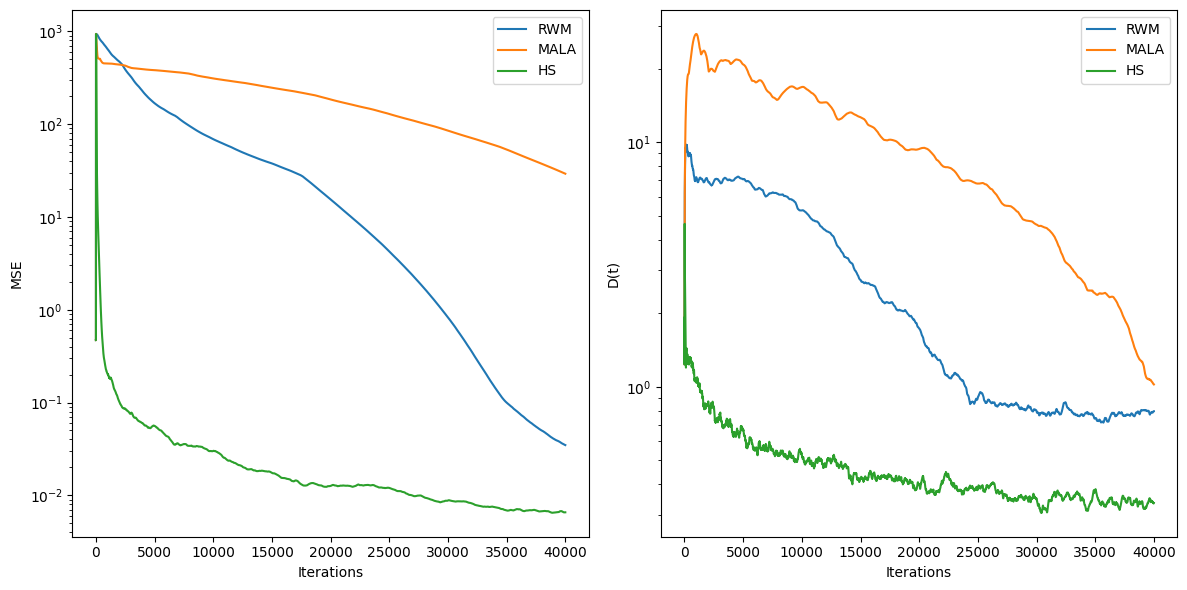

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for MSE
axes[0].plot(pd.DataFrame(RWM_MSE,index=np.linspace(0,N,RWM_MSE.shape[0],dtype = "int")), label="RWM")
axes[0].plot(pd.DataFrame(MALA_MSE,index=np.linspace(0,N,RWM_MSE.shape[0],dtype = "int")), label="MALA")
axes[0].plot(pd.DataFrame(HS_MSE,index=np.linspace(0,N,RWM_MSE.shape[0],dtype = "int")), label="HS")
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('MSE')
axes[0].set_yscale("log")
axes[0].legend()

# Second subplot for D(t)
axes[1].plot(pd.DataFrame(RWM_D), label="RWM")
axes[1].plot(pd.DataFrame(MALA_D), label="MALA")
axes[1].plot(pd.DataFrame(HS_D), label="HS")
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('D(t)')
axes[1].set_yscale("log")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()